# Table of contents
* Part 1. [Getting the data](#1)
* Part 2. [Analyzing the data](#2)
    1. [Distribution of responses](#2.1)\
        1.1. [Informal comparison to Gaussian](#2.1.1)

# Part 1: Getting the data <a class="anchor" id="1"></a>

In [264]:
from datetime import datetime, timedelta
import json
import numpy as np
import pandas as pd
import quantumrandom
import sys
import time
from collections import Counter, defaultdict
from datetime import datetime
from tqdm.notebook import tqdm
# disable locks due due random deadlocks
tqdm.get_lock().locks = []
from websockets import ConnectionClosedError
from web3 import Web3

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
CHAINLINK_BLUE = '#2b5cdc'
CHAINLINK_BLUE_LIGHT = '#698CE5'
COLORS_10 = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3',
             '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd']
PALLETTE_10 = sns.set_palette(sns.color_palette(COLORS_10))

from configs import (
    INFURA_URL,
    INFURA_PROVIDER,
    ETH_USD_PRICE_CONTRACT_ADDR,
    CHAINLINK_ABI
)

convert_unixtime = lambda ts: datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

Connect. Might have to run this a few times.

In [4]:
def connect():
    web3 = Web3(Web3.WebsocketProvider(INFURA_PROVIDER))
    contract = web3.eth.contract(ETH_USD_PRICE_CONTRACT_ADDR, abi=CHAINLINK_ABI)
    return web3, contract

web3, contract = connect()

Approximate earliest Ethereum block with response from this price oracle.

In [5]:
ts_first_response = contract.functions.getTimestamp(1).call()
current_time = time.time()
latest_block = web3.eth.getBlock('latest')['number']
# one day has 86400 seconds
days_ago = (current_time - ts_first_response) // 86400
# ~6,000 blocks a day on Ethereum
# to be safe, we'll add a buffer
buffer = 600
blocks_ago = days_ago * (6000 + buffer)
FIRST_BLOCK = int(latest_block - blocks_ago)
# assert that the first block we've computed does in fact
# occur before the first price contract response
ts_first_block = web3.eth.getBlock(FIRST_BLOCK )['timestamp']
print('FIRST BLOCK: {}.\nFirst USD-ETH price response: {}.'.format(
    convert_unixtime(ts_first_block),
    convert_unixtime(ts_first_response)
))
assert ts_first_block - ts_first_response < 0

FIRST BLOCK: 2020-01-15 06:28:44.
First USD-ETH price response: 2020-01-15 21:10:28.


Populate `df_answers` with all past oracle responses for this price contract. We do this by querying `ResponseReceived` events.

In [6]:
# get timestamps for each answer
answerID_to_timestamp = {}
print('Getting timestamps...')
time.sleep(1)
latest_round = contract.functions.latestRound().call()
for ans_id in tqdm(range(1, latest_round + 1)):
    ts = contract.functions.getTimestamp(ans_id).call()
    answerID_to_timestamp[ans_id] = ts

Getting timestamps...


In [9]:
def get_all_entries(event, first_block, query=None, chunk_size=500):
    '''
    We query the blockchain in chunks to mitigate disconnection issues.
    
    event - `web3._utils.datatypes.Event` type
    first_block - block number where we start querying
    query - optional; specifies which data we want returned from `Filter.get_all_entries()`;
        list of tuples, where elements of tuples are keys in recursive order;
        e.g. [(k1, k2), (k1, k3), (k4,)] will return a dict in the form:
            {
                k1: {
                    k2: [...],
                    k3: [...]
                },
                k4: [...]
            }
    chunk_size - optional; number of contingent blocks we query at a given time
    '''
    if not query:
        result = []
    else:
        result = {}
        for t in query:
            result[t[-1]] = []
    
    web3, contract = connect()
    
    latest_block = web3.eth.getBlock('latest')['number']
    # query blocks in chunks
    nchunks = (latest_block - first_block) // chunk_size
    print("Querying all past data...")
    time.sleep(1)

    for chunk in tqdm(range(nchunks)):

        start_block = first_block + chunk_size * chunk

        # this shit disconnects often so ...
        # max 100 retries ...
        for i in range(100):
            try:
                filter_ = event.createFilter(
                    fromBlock=start_block, # inclusive
                    toBlock=start_block + chunk_size, # inclusive
                )
                entries = filter_.get_all_entries()
                break
            except ConnectionClosedError:
                if i % 10 == 0:
                    print('retrying x{} ...'.format(i))
                time.sleep(1)
                web3, contract = connect()
                continue
        else:
            print('Max retries attempted ... still failed')
            print('Returning partially retrieved data.')
            return result

        for i,entry in enumerate(reversed(entries)):
            if not query:
                result.append(entry)
            else:
                for t in query:
                    d = entry
                    for k in t:
                        d = d[k]
                    result[t[-1]].append(d)

    print('Done.')
    return result

In [8]:
entries = get_all_entries(
    contract.events.ResponseReceived(),
    FIRST_BLOCK,
    query=(('args', 'response'), ('args', 'answerId'), ('args', 'sender')),
    chunk_size=1000
)

Querying all past data...


retrying x0 ...
retrying x10 ...
retrying x20 ...
retrying x30 ...
retrying x40 ...
retrying x50 ...
retrying x60 ...
retrying x70 ...
retrying x80 ...
retrying x90 ...
Max retries attempted ... still failed
Returning partially retrieved data.



In [12]:
# add timestamps
entries['timestamp'] = []
for id_ in entries['answerId']:
    entries['timestamp'].append(answerID_to_timestamp[id_])

df_answers = pd.DataFrame(entries)
df_answers = df_answers.rename(columns={'response': 'price', 'answerId': 'answer_id', 'sender': 'oracle'})

In [14]:
# augment dataframe
# convert timestamp to human readable time
df_answers['date'] = [convert_unixtime(ts) for ts in df_answers['timestamp']]
# convert price into float
df_answers['price_float'] = [p / 1e8 for p in df_answers['price']]

# Part 2: Analyzing the data <a class="anchor" id="2"></a>

In [16]:
df_answers

,price,answer_id,oracle,timestamp,date,price_float
0,16631351520,1,0x0Ce0224ba488ffC0F46bE32b333a874Eb775c613,1579122628,2020-01-15 21:10:28,166.313515
1,16670000000,1,0x83dA1beEb89Ffaf56d0B7C50aFB0A66Fb4DF8cB1,1579122628,2020-01-15 21:10:28,166.700000
2,16614295610,1,0x049Bd8C3adC3fE7d3Fc2a44541d955A537c2A484,1579122628,2020-01-15 21:10:28,166.142956
3,16563811450,1,0x79C6e11bE1C1ed4D91FbE05D458195A2677F14A5,1579122628,2020-01-15 21:10:28,165.638115
4,16643715000,1,0x4565300C576431e5228e8aA32642D5739CF9247d,1579122628,2020-01-15 21:10:28,166.437150
...,...,...,...,...,...,...
6247,17706364416,291,0x4565300C576431e5228e8aA32642D5739CF9247d,1587383481,2020-04-20 11:51:21,177.063644
6248,17700120525,291,0x8cfb1D4269f0daa003CDEa567aC8f76c0647764a,1587383481,2020-04-20 11:51:21,177.001205
6249,17634000000,291,0xF5a3d443FccD7eE567000E43B23b0e98d96445CE,1587383481,2020-04-20 11:51:21,176.340000
6250,17711827892,291,0x992Ef8145ab8B3DbFC75523281DaD6A0981891bb,1587383481,2020-04-20 11:51:21,177.118279


## 2.1 Distribution of price responses per heartbeat, within the last 24 hour <a class="anchor" id="2.1"></a>

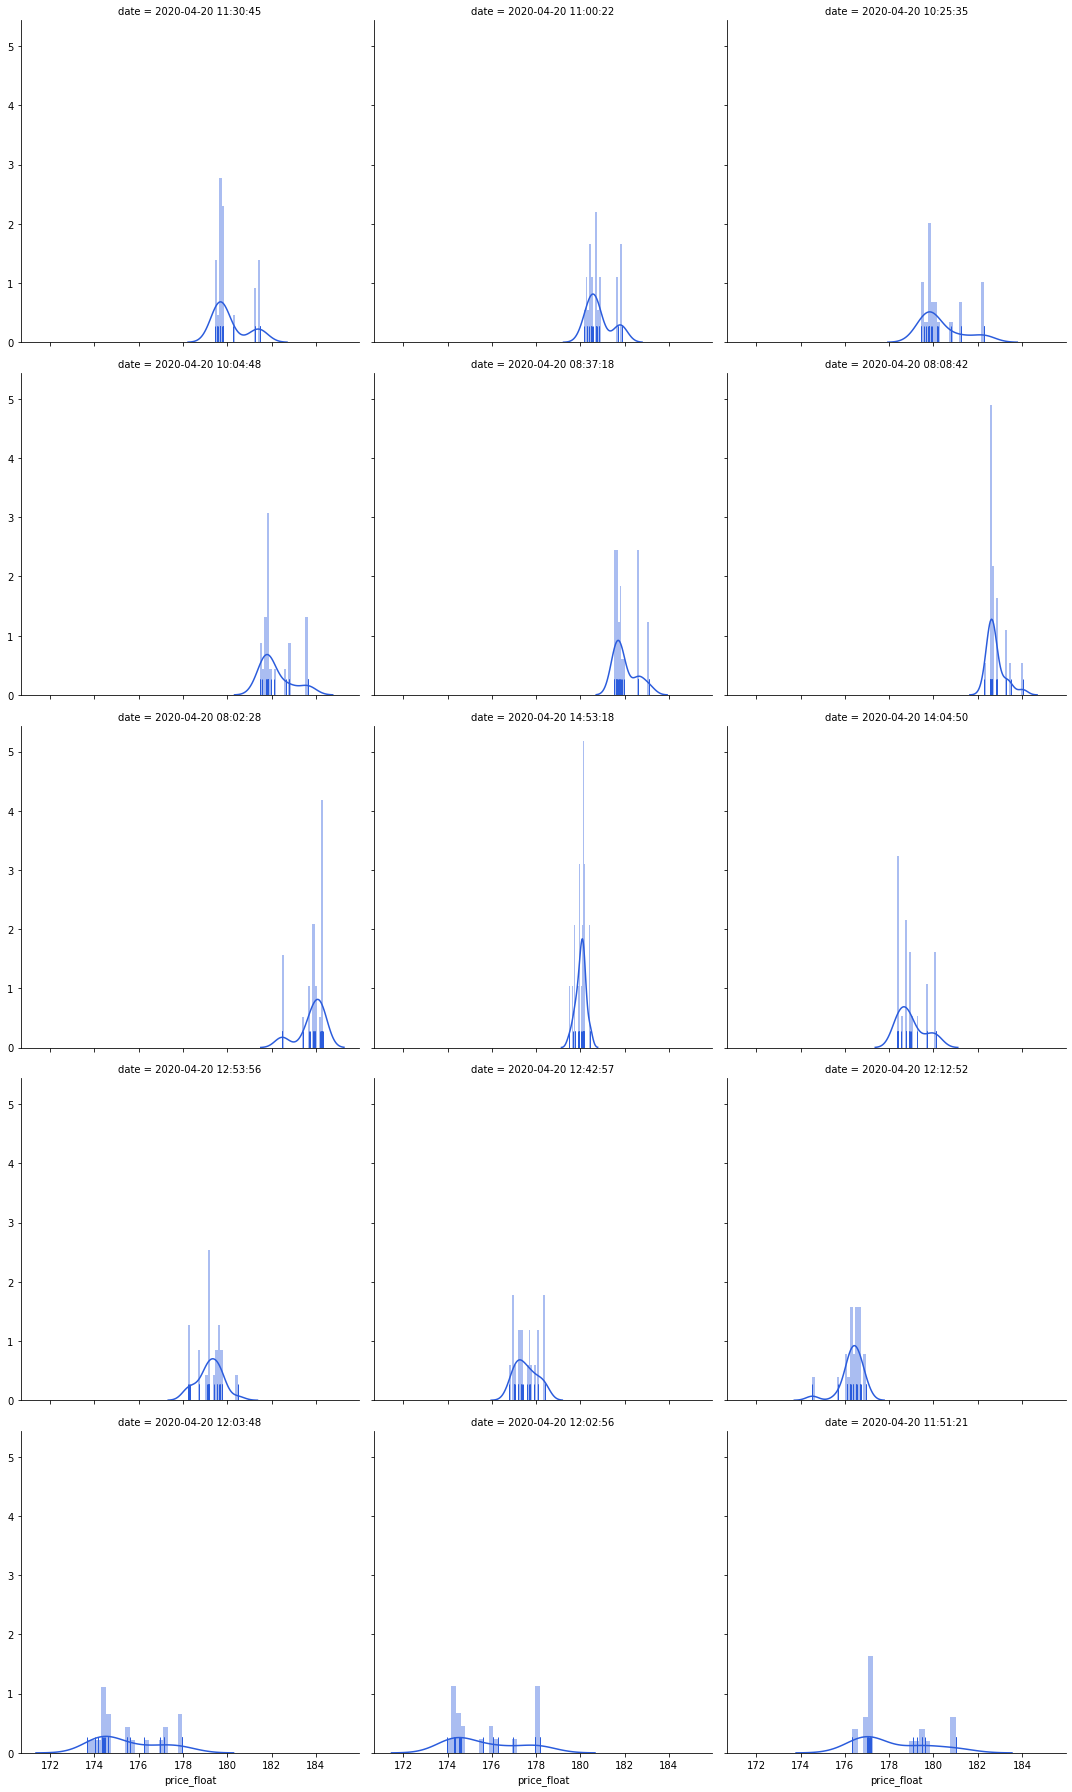

In [256]:
HOURS = 48

ts = time.time() - timedelta(hours=HOURS).total_seconds()
# get last 16
last_ans_id = max(df_answers['answer_id'])
recent_answers = df_answers[(df_answers['timestamp']>=ts) & (df_answers['answer_id']>last_ans_id-15)]
ordered_dates = recent_answers.date.value_counts().index

g = sns.FacetGrid(recent_answers, col="date", row_order=ordered_dates,
                  col_wrap=3, height=5, aspect=1)
g.map(sns.distplot, "price_float", rug=True, **{'bins': 20, 'color': CHAINLINK_BLUE});
#plot.savefig("eth_usd_dists.png")

### Observations:
- We can't assume, based on these distributions, that we are dealing with normally distributed data.
    - This is perhaps due to the fact that we have only ~20 responses. Fitting distributions to small data sets is always a problem. But perhaps there's something else going on here ...
- Often we'll see what appears to be a **bi-modal distribution**.
    - Could this be a result of prices being reported from different exchanges? i.e. some nodes aren't aggregating reponses, instead they report from one or two sources? I could test this hypothesis if I knew where the oracles were getting their data from.
    - Idea: Oracles that aggregate their responses from multiple exchanges are likely to have responses closer to the mean/median. Penalizing oracles with responses further from the center of the distribution would incentivize oracles to gather information from many sources, which is what we want.
        - Caveat: a weighted average of prices from exchanges, where the weight is a function(\*) of *trading volume* is a better aggregation method for price oracles than simple average. This is because prices reported from various exchanges, weighted by the trading volume of those exchanges, is clearly closer to what we envision as the "true price". How do we enforce/incentivise this? Idea: somehow incentivise both accurate (close to mean/median) responses as well as responses representing a large trading volume?
        - (\*) I say *function of* trading volume, because the weighting should be proportional to trading volume, but not exactly equal to it due to interactions such as liquidity (e.g. trading volume is directly correlated with liquidity which has an effect on price.

## 2.1.1 Informal comparison to Gaussian
One might assume that the irregularities with the above distributions is simply an artifact arising from a small sample ($n=21$, see histogram directly below). We can informally test this by plotting samples ($n=21$) from a *true* normal distribution and then visually compare to our plots above.

frequency of total number of oracle responses


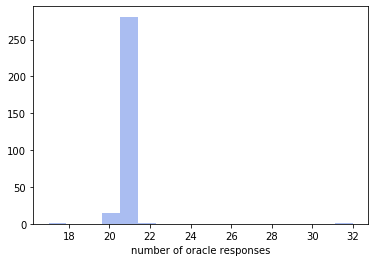

In [249]:
x = df_answers[['answer_id']].groupby(['answer_id']).\
    agg(
        count_col=pd.NamedAgg(column="answer_id", aggfunc="count")
    ).\
    rename(columns={'count_col': 'n_oracles'})

print('frequency of total number of oracle responses')
sns.distplot(x, kde=False, axlabel="number of oracle responses", color=CHAINLINK_BLUE);

Randomly generated samples (n=21) from a normal distribution


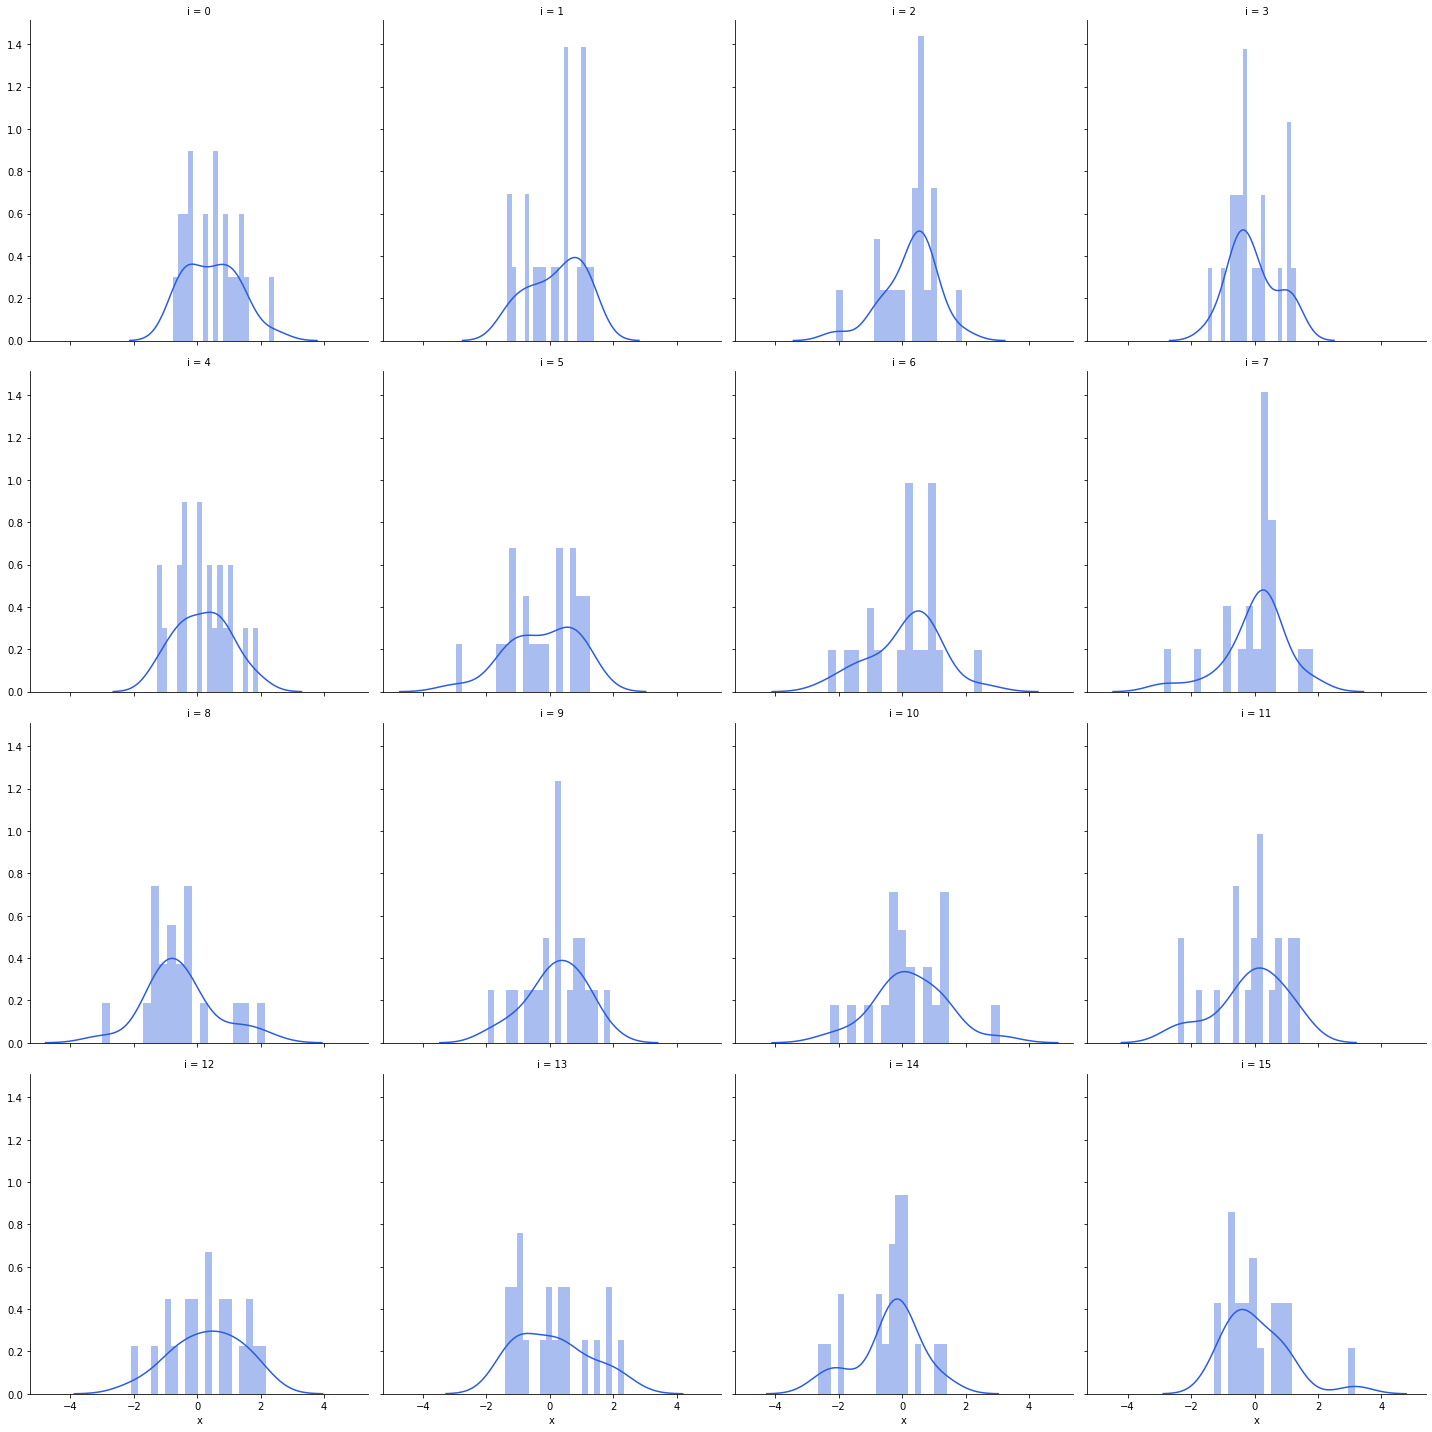

In [248]:
print('Randomly generated samples (n=21) from a normal distribution')
d = defaultdict(list)
for i in range(16):
    # we even seed with a quantum random number generator!
    seed = quantumrandom.get_data()
    np.random.seed(seed)
    x = np.random.normal(size=21)
    for j in range(21):
        d['i'].append(i)
        d['x'].append(x[j])
    
df = pd.DataFrame(d)
g = sns.FacetGrid(df, col="i", col_wrap=4, height=5, aspect=1)
g.map(sns.distplot, "x", **{'bins': 20, 'color': CHAINLINK_BLUE});

### Observations:
- We note, visually, that bimodal distributions are not that common in samples ($n = 21$) generated from true normal distributions, suggesting that there is some underlying factor for why our oracle response distributions are bimodal. Although, we would have to test this more formally before a conclusion.

## 2.2 Exploring variance of responses across time

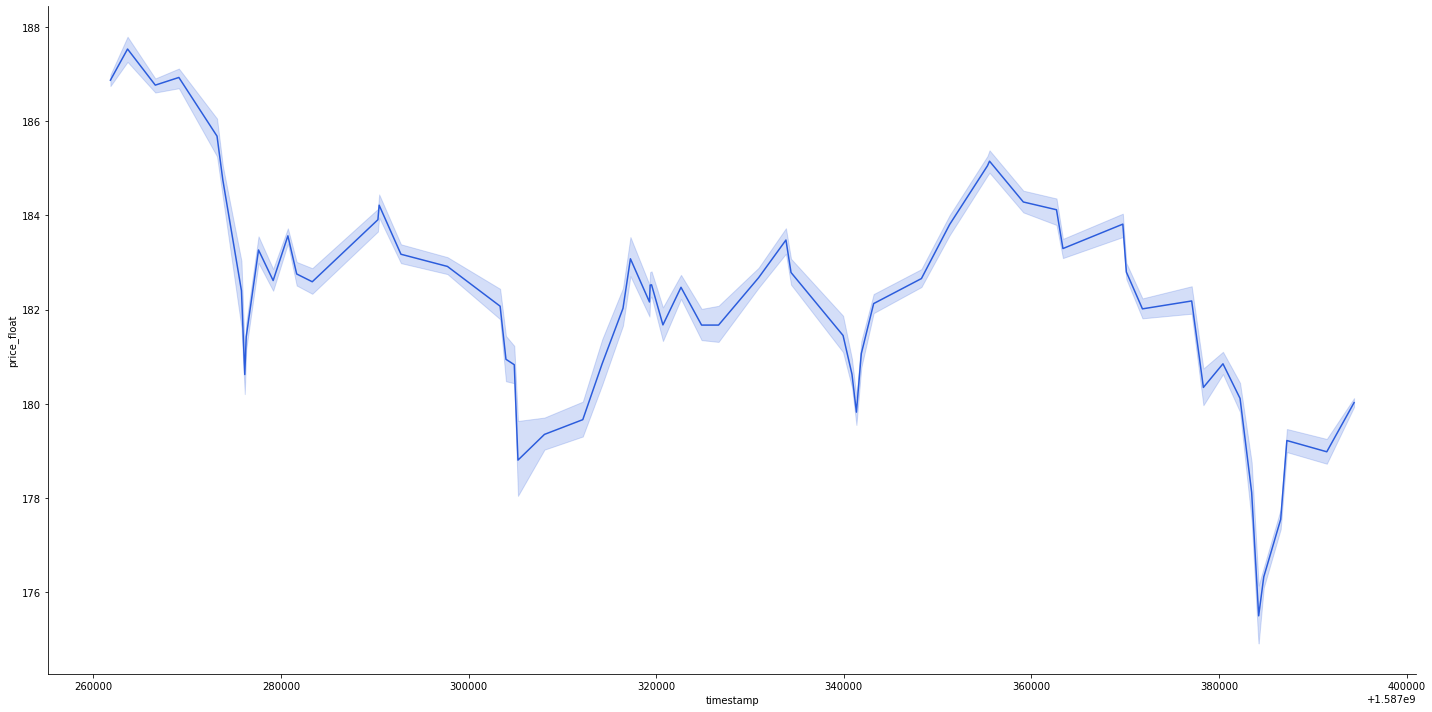

In [247]:
HOURS = 72
ts = time.time() - timedelta(hours=HOURS).total_seconds()
recent_answers = df_answers[df_answers['timestamp']>=ts]

sns.relplot(x="timestamp", y="price_float", kind="line",
            data=recent_answers, height=10, aspect=2, markers=["o"],
            color=CHAINLINK_BLUE);

Violin plots from last 10 rounds; prices are mean centered.


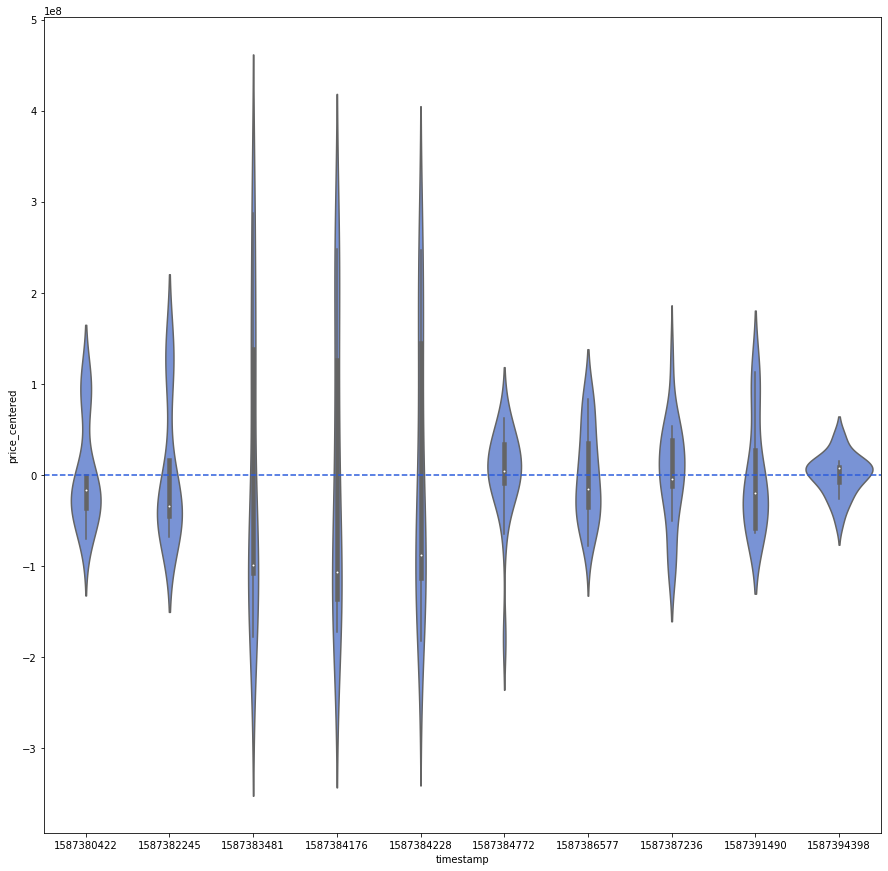

In [267]:
# mean center data
print('Violin plots from last 10 rounds; prices are mean centered.')
recent_answers.loc[:,'price_centered'] = recent_answers.groupby('answer_id')['price'].transform(lambda x: x - x.mean())

even_more_recent_answers = recent_answers[recent_answers['answer_id']>last_ans_id-10]
f, ax = plt.subplots(1, 1, figsize=(15,15))
g = sns.violinplot(ax=ax, x="timestamp", y="price_centered", 
            #height=20, aspect=1,
            #hue="oracle",
            color=CHAINLINK_BLUE_LIGHT,
            data=even_more_recent_answers)
ax = g.axes
ax.axhline(0, ls='--', color=CHAINLINK_BLUE);

### Observations:
- Clearly, variance/deviation varies a lot across time.
- We also note that the violin plots seem to hint at a bimodal distribution in some cases.

## 2.2.1 Variance of responses as a function of price volatility

Addressing the hypothesis that variance between oracle reponses is largely due to price volatility in the time frame in which the price oracle is reporting.

### Gathering data

In [ ]:
# gathering data
CRYPTO_COMPARE_API_URL = 'https://min-api.cryptocompare.com/data/v2/histominute?fsym={from}&tsym={to}&toTs={ts}'

# Rough Work

In [321]:
def median(x):
    n = len(x)
    if n % 2 == 1:
        return x[n//2]
    else:
        return (x[n//2] + x[n//2 + 1]) / 2 

In [618]:
# get start times of Chainlink requests
entries = get_all_entries(
    contract.events.NewRound(),
    FIRST_BLOCK,
    query=[('blockNumber',), ('args', 'roundId')],
    chunk_size=1000
)
df_startblocks = pd.DataFrame(entries)

# get end times of Chainlink requests
entries = get_all_entries(
    contract.events.AnswerUpdated(),
    FIRST_BLOCK,
    query=[('args', 'roundId'), ('args', 'timestamp')],
    chunk_size=1000
)
df_endtimes = pd.DataFrame(entries)

Querying all past data...
659
Done.
Querying all past data...
659
Done.


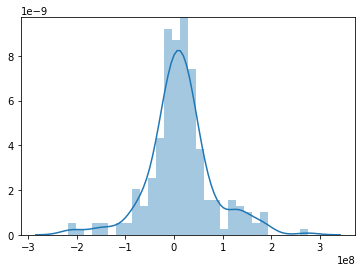

In [337]:
sns.distplot(skews, bins=30)

In [476]:
for event in contract.events:
    print(event)

<class 'web3._utils.datatypes.ResponseReceived'>
<class 'web3._utils.datatypes.OwnershipRenounced'>
<class 'web3._utils.datatypes.OwnershipTransferred'>
<class 'web3._utils.datatypes.ChainlinkRequested'>
<class 'web3._utils.datatypes.ChainlinkFulfilled'>
<class 'web3._utils.datatypes.ChainlinkCancelled'>
<class 'web3._utils.datatypes.AnswerUpdated'>
<class 'web3._utils.datatypes.NewRound'>


In [629]:
web3, contract = connect()

filter_ = contract.events.ResponseReceived().createFilter(
    fromBlock=start_block,
    toBlock=start_block + chunk_size,
)
entries = filter_.get_all_entries()
entries

[AttributeDict({'args': AttributeDict({'response': 17886711436,
   'answerId': 258,
   'sender': '0x8c85a06EB3854Df0d502B2b00169DBfB8B603Bf3'}),
  'event': 'ResponseReceived',
  'logIndex': 1,
  'transactionIndex': 3,
  'transactionHash': HexBytes('0x2ee9424138a2f63ee8e75777e215dae6bbed82d614831cb007d0ed14182b6e7a'),
  'address': '0xF79D6aFBb6dA890132F9D7c355e3015f15F3406F',
  'blockHash': HexBytes('0xd0e38a9302ff5509636574b2f243a6f1f9f1c712f9ad4e501f7410b05dd4bb36'),
  'blockNumber': 9903835}),
 AttributeDict({'args': AttributeDict({'response': 17939186722,
   'answerId': 258,
   'sender': '0x992Ef8145ab8B3DbFC75523281DaD6A0981891bb'}),
  'event': 'ResponseReceived',
  'logIndex': 5,
  'transactionIndex': 5,
  'transactionHash': HexBytes('0xdbae8e9ff47b5cff6f517a2b41b6c046a500c3b02bf6033cbb6ba55484647566'),
  'address': '0xF79D6aFBb6dA890132F9D7c355e3015f15F3406F',
  'blockHash': HexBytes('0xd0e38a9302ff5509636574b2f243a6f1f9f1c712f9ad4e501f7410b05dd4bb36'),
  'blockNumber': 9903835})

In [592]:
filter_ = contract.events.ChainlinkRequested().createFilter(
    fromBlock=start_block,
    toBlock=start_block + chunk_size,
)
entries = filter_.get_all_entries()
entries

[AttributeDict({'args': AttributeDict({'id': b'S\xc0\x11\x893\xe7p\xb2\x02kCkx\x00L\xa47\xa6F\x89\xda2>%#\x05)!\xc1\xe5q\x1a'}),
  'event': 'ChainlinkRequested',
  'logIndex': 0,
  'transactionIndex': 1,
  'transactionHash': HexBytes('0x12e4ab512f1e755100ab4874d29d4d1ce47cd943d5c3eeb12e4ad80c628cc629'),
  'address': '0xF79D6aFBb6dA890132F9D7c355e3015f15F3406F',
  'blockHash': HexBytes('0x89c70afcfe018ff242358e1015a4316e4ea8ebbee7e8dd32c6614143f8416fc4'),
  'blockNumber': 9903833}),
 AttributeDict({'args': AttributeDict({'id': b'\xc5=\xa4\xee\t\xfb{`\x90\x7f\xecK\xa4)~\t}\xa5\x15\xcb\xbc7\x11b\x19\xd7d\x91\xdd\x1b\x96S'}),
  'event': 'ChainlinkRequested',
  'logIndex': 4,
  'transactionIndex': 1,
  'transactionHash': HexBytes('0x12e4ab512f1e755100ab4874d29d4d1ce47cd943d5c3eeb12e4ad80c628cc629'),
  'address': '0xF79D6aFBb6dA890132F9D7c355e3015f15F3406F',
  'blockHash': HexBytes('0x89c70afcfe018ff242358e1015a4316e4ea8ebbee7e8dd32c6614143f8416fc4'),
  'blockNumber': 9903833}),
 AttributeDi

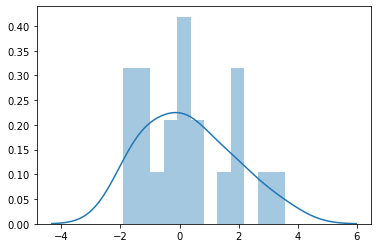

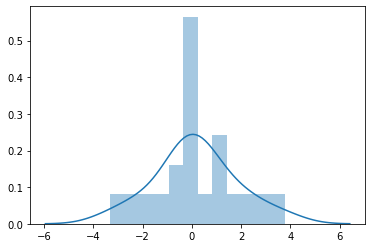

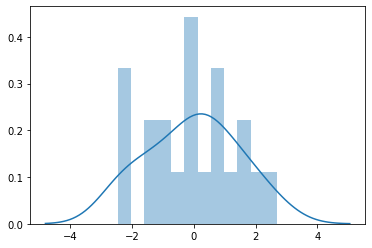

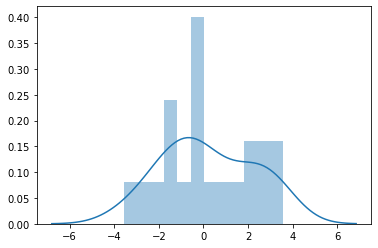

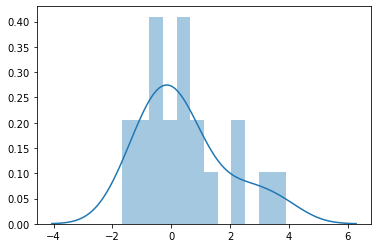

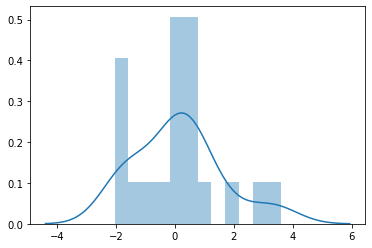

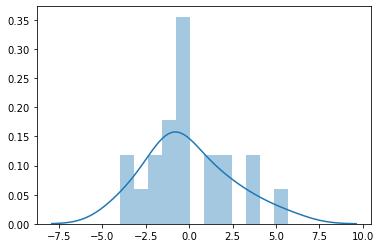

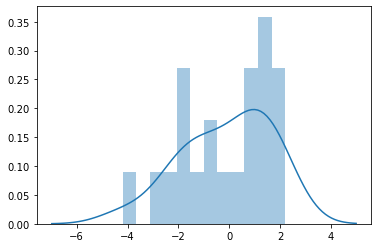

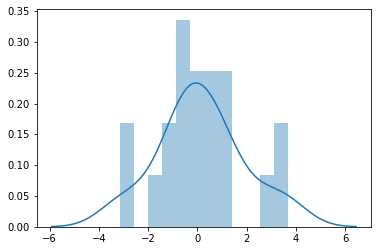

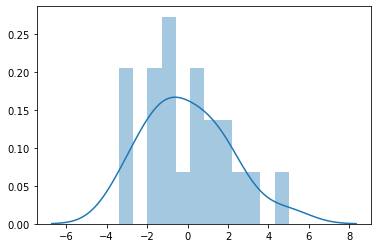

In [664]:
for _ in range(10):
    plt.figure()
    x = np.random.normal(scale=2, size=21)
    sns.distplot(x, bins=12)